# Data Augmentation for Annotated Waste Dataset

## Our, initial dataset looks like this.

garbage-dataset/
├── images/
│   ├── biological_001.jpeg
│   ├── biological_002.jpeg
│   ├── biological_003.jpeg
│   ├── biological_004.jpeg
│   └── ...
└── labels/
    ├── biological_001.txt
    ├── biological_002.txt
    ├── biological_003.txt
    ├── biological_004.txt
    └── ...

We will be applying various data agumentation techniques here.

In [1]:
import os
import random
from PIL import Image, ImageEnhance, ImageDraw
import matplotlib.pyplot as plt
import math

In [2]:
# Directories for input images, annotations, and output files
input_dir = 'garbage-dataset/images'
output_dir = "garbage-dataset/augmented_images"
annotations_dir = 'garbage-dataset/labels'
augmented_annotations_dir = "garbage-dataset/augmented_labels"

In [3]:
# Check if input and annotation directories exist
if not os.path.exists(input_dir):
    raise FileNotFoundError(f"Input directory '{input_dir}' does not exist.")
if not os.path.exists(annotations_dir):
    raise FileNotFoundError(f"Annotations directory '{annotations_dir}' does not exist.")

In [4]:
# Ensure the output and augmented annotations directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(augmented_annotations_dir, exist_ok=True)

In [5]:
# Function to augment an image
# Includes rotation, brightness adjustment, color adjustment, and flipping

def augment_image(image, angle=0, flip=False):
    """Applies a series of augmentations to the input image."""
    # Convert image to RGB mode if it's RGBA
    if image.mode == "RGBA":
        image = image.convert("RGB")

    # Random rotation
    if angle != 0:
        image = image.rotate(angle, expand=True)

    # Random brightness adjustment
    if random.choice([True, False]):
        enhancer = ImageEnhance.Brightness(image)
        factor = random.uniform(0.7, 1.3)  # Brightness factor
        image = enhancer.enhance(factor)

    # Random color adjustment
    if random.choice([True, False]):
        enhancer = ImageEnhance.Color(image)
        factor = random.uniform(0.7, 1.3)  # Color factor
        image = enhancer.enhance(factor)

    # Random horizontal flip
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    return image

In [6]:
# Function to adjust annotations for augmented images
def augment_annotation(annotation_path, output_path, angle=0, flip=False, image_width=0, image_height=0):
    """Adjusts annotations based on augmentations applied."""
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    augmented_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id, x_center, y_center, width, height = map(float, parts)

        # Convert YOLO format to absolute coordinates
        x_center_abs = x_center * image_width
        y_center_abs = y_center * image_height
        box_width_abs = width * image_width
        box_height_abs = height * image_height

        # Apply horizontal flip
        if flip:
            x_center_abs = image_width - x_center_abs

        # Apply rotation
        if angle != 0:
            angle_rad = math.radians(angle)
            x_new = math.cos(angle_rad) * (x_center_abs - image_width / 2) - math.sin(angle_rad) * (y_center_abs - image_height / 2) + image_width / 2
            y_new = math.sin(angle_rad) * (x_center_abs - image_width / 2) + math.cos(angle_rad) * (y_center_abs - image_height / 2) + image_height / 2
            x_center_abs, y_center_abs = x_new, y_new

        # Convert back to YOLO format
        x_center = x_center_abs / image_width
        y_center = y_center_abs / image_height

        augmented_lines.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    # Save the adjusted annotation
    with open(output_path, 'w') as file:
        file.writelines(augmented_lines)

In [7]:
# Process images and annotations
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
if not image_files:
    raise ValueError(f"No image files found in the directory '{input_dir}'.")

In [8]:
# Perform augmentation for all images
for img_file in image_files:
    try:
        # Open the image file
        img_path = os.path.join(input_dir, img_file)
        annotation_path = os.path.join(annotations_dir, f"{os.path.splitext(img_file)[0]}.txt")

        if not os.path.exists(annotation_path):
            print(f"Annotation file for {img_file} not found. Skipping.")
            continue

        with Image.open(img_path) as img:
            width, height = img.size

            # Perform augmentations and save new images and annotations
            for i in range(5):  # Generate 5 augmented versions for each image
                angle = 0
                flip = random.choice([True, False])
                augmented_img = augment_image(img.copy(), angle=angle, flip=flip)

                # Save the augmented image and annotation
                output_img_path = os.path.join(output_dir, f"aug_{i}_{img_file}")
                augmented_img.save(output_img_path, format="JPEG")

                output_annotation_path = os.path.join(augmented_annotations_dir, f"aug_{i}_{os.path.splitext(img_file)[0]}.txt")
                augment_annotation(annotation_path, output_annotation_path, angle=angle, flip=flip, image_width=width, image_height=height)

    except Exception as e:
        print(f"Error processing file {img_file}: {e}")

In [9]:
# Function to draw annotations on an image
def draw_annotations(image, annotation_path):
    """Draws bounding boxes on the image based on the annotations."""
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    draw = ImageDraw.Draw(image)
    width, height = image.size

    for line in lines:
        parts = line.strip().split()
        class_id, x_center, y_center, box_width, box_height = map(float, parts)
        
        # Convert YOLO format to box coordinates
        x_min = (x_center - box_width / 2) * width
        x_max = (x_center + box_width / 2) * width
        y_min = (y_center - box_height / 2) * height
        y_max = (y_center + box_height / 2) * height

        # Set color based on class_id
        if class_id == 1:
            color = "red"
        elif class_id == 0:
            color = "green"
        else:
            color = "blue"  # Default color for other classes

        # Draw the rectangle and label
        draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=2)
        draw.text((x_min, y_min), str(int(class_id)), fill=color)

    return image

Saved augmented: aug_0_biological_001.jpg with rotation 4° and flip=True
Saved augmented: aug_1_biological_001.jpg with rotation -1° and flip=True
Saved augmented: aug_2_biological_001.jpg with rotation 15° and flip=True
Saved augmented: aug_3_biological_001.jpg with rotation 0° and flip=True
Saved augmented: aug_4_biological_001.jpg with rotation 3° and flip=False


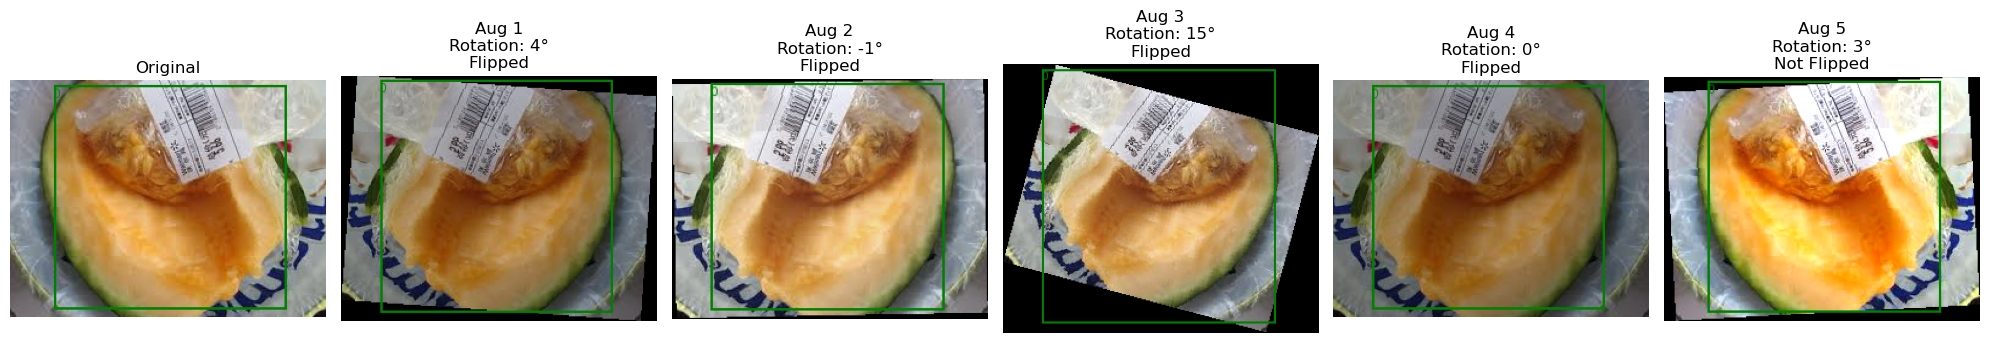

In [10]:
# Select a single image
img_file = image_files[0]  # Or any specific image
img_path = os.path.join(input_dir, img_file)
annotation_path = os.path.join(annotations_dir, f"{os.path.splitext(img_file)[0]}.txt")

if not os.path.exists(annotation_path):
    print(f"Annotation file for {img_file} not found.")
else:
    try:
        with Image.open(img_path) as img:
            width, height = img.size

            # Save and annotate original image
            annotated_img = draw_annotations(img.copy(), annotation_path)

            plt.figure(figsize=(20, 5))

            # Plot original image
            plt.subplot(1, 6, 1)
            plt.imshow(annotated_img)
            plt.title("Original")
            plt.axis('off')

            # Generate and plot 5 augmented images with annotation and titles
            for i in range(5):
                angle = random.randint(-15, 15)
                flip = random.choice([True, False])

                augmented_img = augment_image(img.copy(), angle=angle, flip=flip)

                # Save augmented image and annotation
                aug_img_name = f"aug_{i}_{img_file}"
                aug_img_path = f"garbage-dataset/augmented_images/{aug_img_name}"
                augmented_img.convert("RGB").save(aug_img_path, format="JPEG")

                aug_ann_name = f"aug_{i}_{os.path.splitext(img_file)[0]}.txt"
                aug_ann_path = os.path.join(augmented_annotations_dir, aug_ann_name)
                augment_annotation(
                    annotation_path,
                    aug_ann_path,
                    angle=angle,
                    flip=flip,
                    image_width=width,
                    image_height=height
                )

                # Draw annotations on augmented image
                annotated_aug_img = draw_annotations(augmented_img.copy(), aug_ann_path)

                plt.subplot(1, 6, i + 2)
                plt.imshow(annotated_aug_img)

                flip_text = "Flipped" if flip else "Not Flipped"
                plt.title(f"Aug {i+1}\nRotation: {angle}°\n{flip_text}")
                plt.axis('off')

                print(f"Saved augmented: {aug_img_name} with rotation {angle}° and flip={flip}")

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error processing {img_file}: {e}")